## Importing Libraries

In [34]:
import os #will be used for creating directories, etc.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import torch
import torchvision
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors
from torch.nn import functional as F

from torch import nn
from torch.autograd import Variable
import torchvision.transforms.functional as fn

from PIL import Image

from time import time

## Uploading Data

In [18]:
train_data = pd.read_csv('archive/peopleDevTrain.csv')

no_of_diff_people = train_data.shape[0]

print('number of different names', train_data.shape[0])
print(train_data.iloc[278,0])

img = Image.open("archive/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg")

red_dim = 64
img = fn.resize(img, size=[red_dim, red_dim])

img

convert_tensor = transforms.Compose([
    transforms.ToTensor()
])

convert_tensor(img)

print(img.size)

number of different names 4038
Arnold_Schwarzenegger
(64, 64)


In [19]:
def img2tensor (filepath):
    img = Image.open(filepath)
    img = fn.resize(img, size=[red_dim, red_dim])
    image = convert_tensor(img)
    return image

In [20]:
trial_number = 100
image = torch.tensor(np.zeros(shape= (trial_number,3,red_dim,red_dim)))
for number in range(trial_number):
    name = train_data.iloc[number,0]
    no_of_images = train_data.iloc[number,1]
#     print(name)
#     print(no_of_images)

    for i in range(no_of_images):
        path = "archive/lfw-deepfunneled/lfw-deepfunneled/"
        photo_number = i+1
        if i < 9:
            file_path = path + name + '/'+ name + '_000'  + str(photo_number) +'.jpg'
        elif i>9:
            file_path = path + name + '/'+ name + '_00'  + str(photo_number) +'.jpg'
        else:
            break
            
#         file_path = path + name + '/'+ name + '_0001' +'.jpg'
        image[number,:,:,:] = img2tensor(file_path)
#         print(image.size())

torch.Size([3, 64, 64])


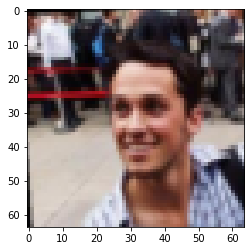

In [21]:
trial_image = image[trial_number-1,:,:,:]
print(trial_image.size())
plt.imshow(trial_image.permute(1, 2, 0)  )

In [22]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.dtype(float32)
    return Variable(x)

In [23]:
image = to_var(image.view(image.size(0), -1))
print(image.size())
# image = torch.flatten(image)
print(image.size())
input_dim = image.size()

torch.Size([100, 12288])
torch.Size([100, 12288])


## Create Auto Encoder

In [24]:
# We are going to create three neural nets - Encoder, Decoder, and Adversarial

# Encoder
class ENC_net(nn.Module): 
    def __init__(self, X_dim, N, z_dim):
        super(ENC_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss
    

# Decoder
class DEC_net(nn.Module):  
    def __init__(self, X_dim, N, z_dim):
        super(DEC_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)
    
    
# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self, N, z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

## Training Parameters

In [25]:
# Create Autoencoder model
z_red_dims = 120
EPS = 1e-15

Q = ENC_net(3*red_dim*red_dim, 1000, z_red_dims)
P = DEC_net(3*red_dim*red_dim, 1000, z_red_dims)
D_gauss = D_net_gauss(500, z_red_dims)

In [26]:
### Optimizer

# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=gen_lr)

#regularizing optimizers
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(D_gauss.parameters(), lr=reg_lr)

In [27]:
# criterion = nn.MSELoss()     #Binary cross-entropy loss for each pixel


In [28]:
# image = image.type(torch.float32)
# out_image = ae(image)
# out_image = out_image.type(torch.float32)
# loss = criterion(out_image, image)
        
# optimizer.zero_grad()
# loss.backward()         # calculate gradients
# optimizer.step() 

## Training

In [37]:
for epoch in range(num_epochs):
    t0 = time()
    for i in range(trial_number):
        
        # flatten the image
        image = image.type(torch.float32)
        image = to_var(image.view(image.size(0), -1))
        
        # Reconstruction loss
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        z_sample   = Q(image)   # encode to z
        X_sample   = P(z_sample) # decode to X reconstruction
        recon_loss = F.binary_cross_entropy(X_sample+EPS, image+EPS)
        
        recon_loss.backward()
        optim_P.step()
        optim_Q_enc.step()

        # Discriminator
        ## true prior is random normal (randn)
        ## this is constraining the Z-projection to be normal!

        Q.eval()
        z_real_gauss = to_var(torch.randn(image.size()[0], z_red_dims) * 5.)
        D_real_gauss = D_gauss(z_real_gauss)

        z_fake_gauss = Q(image)
        D_fake_gauss = D_gauss(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

        D_loss.backward()
        optim_D.step()
        
        if (epoch+1) % 1 == 0:
            z_fixed        = Q(trial_image)   # encode to z
            reconst_images = P(z_fixed)   # decode to X reconstruction
            reconst_images = reconst_images.view(reconst_images.size(0), 3, red_dim, red_dim)
    #         torchvision.utils.save_image(reconst_images.data.cpu(), './data/reconst_images_%d.png' % int((step+1)/iter_per_epoch))

            z_sample       = to_var(torch.randn(image.size()[0], z_red_dims) * 5.)
            sample_images  = P(z_sample)
            sample_images  = sample_images.view(sample_images.size(0), 3, red_dim, red_dim)
    #         torchvision.utils.save_image(sample_images.data.cpu(), './results/sample_images_%d.png' % int((step+1)/iter_per_epoch))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x64 and 12288x1000)

## Verifying on Train Data

In [ ]:
# random_ip_image = image[trial_number-1,:,:,:]
new_ip_image = trial_image.view(3, red_dim, red_dim)
print(new_ip_image.dtype)
transform_toimage = transforms.ToPILImage()

# plt.imshow(transform_toimage(new_out_image))
plt.imshow(new_ip_image.permute(1,2,0))

In [ ]:
ip_image = trial_image.type(torch.float32)
print(ip_image.size())
ip_image = torch.flatten(to_var(ip_image.view(ip_image.size(0), -1)))
print(ip_image.size())
recon_image = ae(ip_image)
print(recon_image.size())
recon_image = recon_image.reshape(3,red_dim,red_dim)
print(recon_image.size())


transform_toimage = transforms.ToPILImage()

plt.imshow(transform_toimage(recon_image))

## Testing Data

In [ ]:
number = trial_number+2000
# test_image = torch.tensor(np.zeros(shape = (1,3,red_dim,red_dim)))

test_name = train_data.iloc[number,0]
print('name:', name)

test_file_path = path + test_name + '/'+ test_name + '_0001' +'.jpg'
test_image = img2tensor(test_file_path)

plt.imshow(test_image.permute(1, 2, 0)  )

In [ ]:
test_ip_image = test_image.type(torch.float32)
print(test_ip_image.size())
test_ip_image = torch.flatten(to_var(test_ip_image.view(test_ip_image.size(0), -1)))
print(test_ip_image.size())
test_recon_image = ae(test_ip_image)
test_recon_image = test_recon_image.type(torch.float32)
print(test_recon_image.size())
# test_recon_loss = loss(test_recon_image, test_ip_image)
# print('Loss:', test_recon_loss)
test_recon_image = test_recon_image.reshape(3,red_dim,red_dim)
print(recon_image.size())


transform_toimage = transforms.ToPILImage()

plt.imshow(transform_toimage(test_recon_image))